clean and filter dataset by Status

In [62]:
import re
import pandas as pd

# --- 1) Load file ---
file_path = r"C:\Users\moham\OneDrive\Desktop\IOT\DATA\methanol.xlsx"
df = pd.read_excel(file_path)

# --- 2) Clean messy column names (remove _x000D_, newlines, extra spaces) ---
def clean_name(col: str) -> str:
    s = str(col)
    s = re.sub(r'_x000D_', ' ', s, flags=re.IGNORECASE)  # remove Excel's CR tokens
    s = s.replace('\r', ' ').replace('\n', ' ')          # remove line breaks
    s = re.sub(r'\s+', ' ', s).strip()                   # collapse spaces
    return s

df.columns = [clean_name(c) for c in df.columns]

print("Cleaned columns:\n", df.columns.tolist())

# --- 3) Find the methanol molar fraction column robustly ---
cands = []
for c in df.columns:
    lc = c.lower()
    if "methanol" in lc and ("molar" in lc or "mole" in lc) and "fraction" in lc:
        cands.append(c)
# common alternates (uncomment/add more if needed)
if not cands:
    for c in df.columns:
        lc = c.lower()
        if any(k in lc for k in ["xmeoh", "meoh x", "meoh_x", "molefrac_meoh"]):
            cands.append(c)

assert cands, "Couldn't find a 'methanol molar fraction' column. Print df.columns and set it manually."
methanol_col = cands[0]
print("Detected methanol fraction column:", methanol_col)

# --- 4) Find Status column (case-insensitive) ---
status_col = None
for c in df.columns:
    if c.lower() == "status":
        status_col = c
        break
if status_col is None:
    for c in df.columns:
        if "status" in c.lower():
            status_col = c
            break
assert status_col is not None, "Couldn't find a 'Status' column."

# --- 5) Coerce methanol fraction to numeric (drop non-numeric) ---
df[methanol_col] = pd.to_numeric(df[methanol_col], errors="coerce")

# --- 6) Filter: methanol fraction present AND Status == OK ---
mask_ok = df[status_col].astype(str).str.strip().str.upper().eq("OK")
mask_has_meoh = df[methanol_col].notna()
df_clean = df[mask_ok & mask_has_meoh].copy().reset_index(drop=True)

print("✅ Cleaned shape:", df_clean.shape)
df_clean.head()


Cleaned columns:
 ['Row/Case', 'Status', 'VARY 1 HHX3 PARAM TEMP C', 'VARY 2 HHX3 PARAM PRES BAR', 'VARY 3 RECYCLE RECYCLED FRAC FRAC', 'VARY 4 SYNGAS MIXED TOTAL MO LEFLOW KMOL/HR', 'METHANOL molar fraction']
Detected methanol fraction column: METHANOL molar fraction
✅ Cleaned shape: (6808, 7)


,Row/Case,Status,VARY 1 HHX3 PARAM TEMP C,VARY 2 HHX3 PARAM PRES BAR,VARY 3 RECYCLE RECYCLED FRAC FRAC,VARY 4 SYNGAS MIXED TOTAL MO LEFLOW KMOL/HR,METHANOL molar fraction
0,1,OK,130.0,75.0,0.75,8587.00000,0.136849
1,2,OK,130.0,75.0,0.75,8905.11111,0.136788
2,3,OK,130.0,75.0,0.75,9223.22222,0.136735
3,4,OK,130.0,75.0,0.75,9541.33333,0.136689
4,5,OK,130.0,75.0,0.75,9859.44444,0.136642


SAVE cleaned file

In [63]:
out_path = r"C:\Users\moham\OneDrive\Desktop\IOT\DATA\methanol_cleaned.xlsx"
df_clean.to_excel(out_path, index=False)
print("Saved to:", out_path)


Saved to: C:\Users\moham\OneDrive\Desktop\IOT\DATA\methanol_cleaned.xlsx


CONFIGURATION

In [64]:
# ============================================================
# 0️⃣ CONFIGURATION
# ============================================================
import pandas as pd
import numpy as np

# Path to your cleaned dataset
CLEAN_PATH = r"C:\Users\moham\OneDrive\Desktop\IOT\DATA\methanol_cleaned.xlsx"

# Column names from your cleaned file
COL_TEMP  = 'VARY 1 HHX3 PARAM TEMP C'
COL_PRES  = 'VARY 2 HHX3 PARAM PRES BAR'
COL_RECYC = 'VARY 3 RECYCLE RECYCLED FRAC FRAC'
COL_FLOW  = 'VARY 4 SYNGAS MIXED TOTAL MO LEFLOW KMOL/HR'
COL_Y     = 'METHANOL molar fraction'

INPUT_COLS = [COL_TEMP, COL_PRES, COL_RECYC, COL_FLOW]
OUTPUT_COLS = [COL_Y]

# Operating ranges
RANGE_TEMP  = (130.0, 281.1111)
RANGE_PRES  = (75.0, 150.0)
RANGE_RECYC = (0.75, 0.99)
RANGE_FLOW  = (8587.0, 11450.0)


LOAD & RANDOMIZE ROWS

In [65]:
# ============================================================
# 1️⃣ LOAD & RANDOMIZE ROWS
# ============================================================
df = pd.read_excel(CLEAN_PATH)

# Ensure numeric and drop invalids
for c in INPUT_COLS + OUTPUT_COLS:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df = df.dropna(subset=INPUT_COLS + OUTPUT_COLS).reset_index(drop=True)

# Randomize rows (keeps input-output correlations)
rng = np.random.default_rng(42)
perm = rng.permutation(len(df))
df = df.iloc[perm].reset_index(drop=True)

print("✅ Cleaned & randomized dataset loaded.")
print("Total rows:", len(df))


✅ Cleaned & randomized dataset loaded.
Total rows: 6808


PLIT DATA INTO TRAIN, VALIDATION, TEST

In [66]:
# ============================================================
# 2️⃣ SPLIT DATA INTO TRAIN, VALIDATION, TEST
# ============================================================
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42)
val_df,   test_df = train_test_split(temp_df, test_size=0.50, random_state=42)

print(f"Split sizes -> Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Split sizes -> Train: 4765, Val: 1021, Test: 1022


NORMALIZE DATA

In [67]:
# ============================================================
# 3️⃣ NORMALIZE DATA
# ============================================================
from sklearn.preprocessing import MinMaxScaler

scaler_x = MinMaxScaler().fit(train_df[INPUT_COLS])
scaler_y = MinMaxScaler().fit(train_df[OUTPUT_COLS])

X_train = scaler_x.transform(train_df[INPUT_COLS])
y_train = scaler_y.transform(train_df[OUTPUT_COLS])
X_val   = scaler_x.transform(val_df[INPUT_COLS])
y_val   = scaler_y.transform(val_df[OUTPUT_COLS])
X_test  = scaler_x.transform(test_df[INPUT_COLS])
y_test  = scaler_y.transform(test_df[OUTPUT_COLS])

print("✅ Data normalized successfully.")


✅ Data normalized successfully.


DENSITY-BASED SAMPLE WEIGHTING (helps with clustered data)

In [68]:
# ============================================================
# 4️⃣ DENSITY-BASED SAMPLE WEIGHTING (helps with clustered data)
# ============================================================
from sklearn.preprocessing import KBinsDiscretizer

n_bins = 10
kbd = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
bins = kbd.fit_transform(X_train).astype(int)

# Flatten 4D bins into a single id
bin_ids = (bins[:,0]*(n_bins**3) + bins[:,1]*(n_bins**2) + bins[:,2]*n_bins + bins[:,3]).astype(int)
counts = np.bincount(bin_ids, minlength=n_bins**4).astype(float)

weights = 1.0 / (counts[bin_ids] + 1e-12)
weights /= np.mean(weights)
weights = np.clip(weights, 0, np.quantile(weights, 0.99))

print("Sample weights summary -> min:", weights.min(), "median:", np.median(weights), "max:", weights.max())


Sample weights summary -> min: 1.0000000000000002 median: 1.0000000000000002 max: 1.0000000000000002


ANN MODEL TRAINING

In [69]:
# ============================================================
# 5️⃣ ANN MODEL TRAINING
# ============================================================
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, GaussianNoise
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

tf.keras.backend.clear_session()

model = Sequential([
    GaussianNoise(0.01, input_shape=(4,)),
    Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse', metrics=['mae'])

early   = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-5)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=400,
    batch_size=64,
    callbacks=[early, plateau],
    verbose=1,
    sample_weight=weights
)


Epoch 1/400


C:\Users\moham\PyCharmMiscProject\.venv\Lib\site-packages\keras\src\layers\regularization\gaussian_noise.py:29: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0766 - mae: 0.2049 - val_loss: 0.0145 - val_mae: 0.0818 - learning_rate: 0.0010
Epoch 2/400
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0248 - mae: 0.1133 - val_loss: 0.0083 - val_mae: 0.0520 - learning_rate: 0.0010
Epoch 3/400
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0180 - mae: 0.0928 - val_loss: 0.0084 - val_mae: 0.0596 - learning_rate: 0.0010
Epoch 4/400
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0153 - mae: 0.0833 - val_loss: 0.0064 - val_mae: 0.0450 - learning_rate: 0.0010
Epoch 5/400
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0134 - mae: 0.0764 - val_loss: 0.0055 - val_mae: 0.0396 - learning_rate: 0.0010
Epoch 6/400
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0123 - mae: 0.0731 - val_loss: 0.0053 - val_mae: 0.0384 - learning_rate: 0.0010
Epoch 7/400
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0109 - mae: 0.0678 - val_loss: 0.0040 - val_mae: 0.0206 - learning_rate: 0.0010
Epoch 8/400
75/75 ━━━━━━━

In [70]:
# ============================================================
# 6️⃣ VALIDATION & TEST PERFORMANCE
# ============================================================
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

y_pred_test_scaled = model.predict(X_test, verbose=0)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_true_test = scaler_y.inverse_transform(y_test)

r2 = r2_score(y_true_test, y_pred_test)
mse = mean_squared_error(y_true_test, y_pred_test)
mae = mean_absolute_error(y_true_test, y_pred_test)

print("\n📊 TEST SET PERFORMANCE:")
print(f"R² = {r2:.4f}")
print(f"MSE = {mse:.6f}")
print(f"MAE = {mae:.6f}")



📊 TEST SET PERFORMANCE:
R² = 0.9973
MSE = 0.000002
MAE = 0.001034


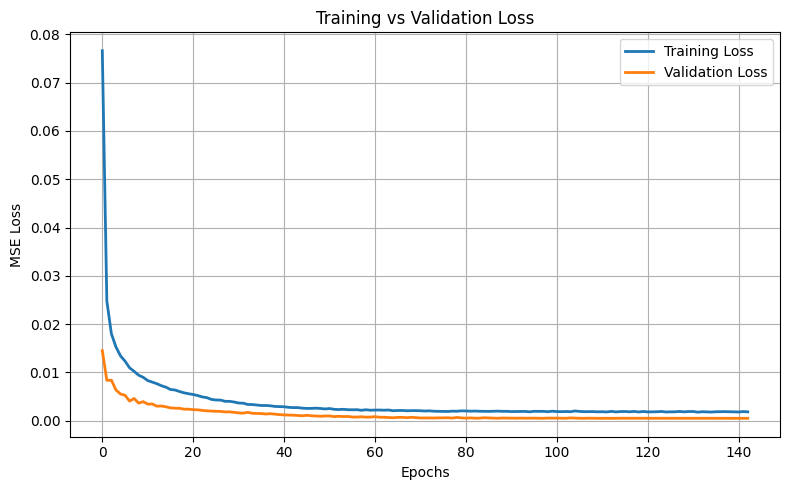

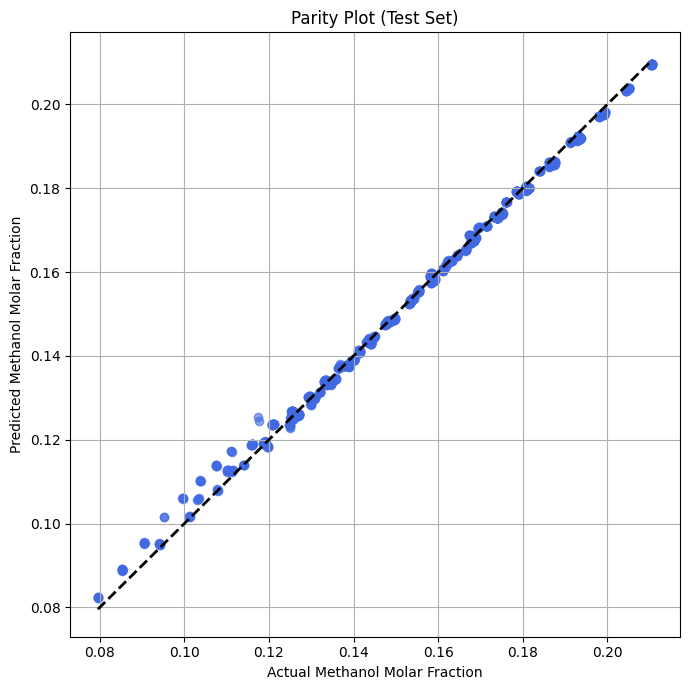

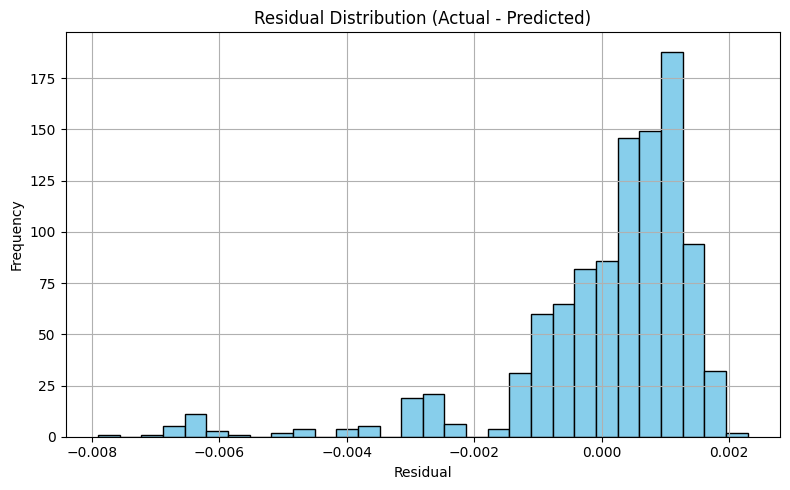

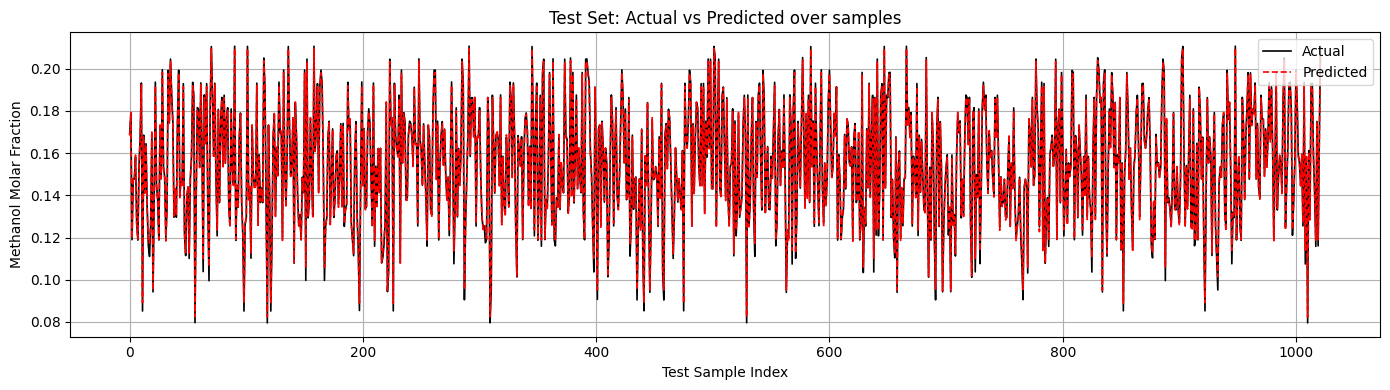

In [71]:
# ============================================================
# 8️⃣ VISUALIZATION
# ============================================================
import matplotlib.pyplot as plt

# Loss curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epochs'); plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# Parity plot (Actual vs Predicted)
plt.figure(figsize=(7,7))
plt.scatter(y_true_test, y_pred_test, alpha=0.6, color='royalblue')
lo, hi = float(np.min(y_true_test)), float(np.max(y_true_test))
plt.plot([lo, hi], [lo, hi], 'k--', lw=2)
plt.xlabel('Actual Methanol Molar Fraction')
plt.ylabel('Predicted Methanol Molar Fraction')
plt.title('Parity Plot (Test Set)')
plt.grid(True); plt.tight_layout(); plt.show()

# Residuals histogram
residuals = y_true_test - y_pred_test
plt.figure(figsize=(8,5))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.title("Residual Distribution (Actual - Predicted)")
plt.xlabel("Residual"); plt.ylabel("Frequency")
plt.grid(True); plt.tight_layout(); plt.show()

# Index plot (Actual vs Predicted)
idx = np.arange(len(y_true_test))
plt.figure(figsize=(14,4))
plt.plot(idx, y_true_test, '-', label='Actual', linewidth=1.2, color='black')
plt.plot(idx, y_pred_test, '--', label='Predicted', linewidth=1.2, color='red')
plt.xlabel('Test Sample Index'); plt.ylabel('Methanol Molar Fraction')
plt.title('Test Set: Actual vs Predicted over samples')
plt.legend(loc='upper right'); plt.grid(True); plt.tight_layout(); plt.show()
